# **Analyse de sentiments sur les vaccins COVID administrés en France**
**Projet Python - 2A ENSAE**

KOAGNE FONGUIENG Florette, KONKOBO Idrissa

# Introduction

+ **Objectifs** : il s'agissait de conduire une analyse de sentiments sur les vaccins administrés en France, sujet qui ne nous semblait intéressant d'un point de vue visualisation, manipulation et modélisation. Initialement, l'idée était de croiser les données tweets avec les chiffres journaliers de vaccination et des effets indésirables. Cependant, l'API mis en place par l'Assurance Maladie donnait accès à des statistiques hebdomadaires de la vaccination. Nous avons finalement décidé de travailer uniquement avec les tweets .

+ **Projet** : après la phase de récupération des données, le projet s'étale en 4 parties. Nous avions d'abord réaliser un traitement des données incluant le nettoyage des tweets, la créations de feature, ainsi que leurs labelisation par sentiment avec TextBlob. Ensuite, nous avions complété l'analyse de données par des statistiques descriptives, de la visualisation notamment des wordclouds. Enfin, nous avions tenté une modélisation avec les sentiments désignés par TextBlob en implémentant une LDA et une regréssion logistique.

# Importation

In [ ]:
# !pip install demoji

In [ ]:
# !pip install textblob

In [ ]:
# !pip install afinn

In [ ]:
# !pip install wordcloud

In [ ]:
# !pip install textblob-fr

In [ ]:
# !pip install plotly

In [ ]:
# !pip install spacy

In [ ]:
# !pip install gensim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns
import datetime
import random
from PIL import Image
from afinn import Afinn
from datetime import *
import demoji
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
from nltk.corpus import stopwords
from random import random, seed
import sklearn
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
import spacy
import gensim.corpora as corpora 
from pprint import pprint
import gensim.models

In [2]:
pd.options.display.max_colwidth = 50

**NB**: Exécuter en ligne de commande le code suivante : *python -m spacy download fr_core_news_md*

In [3]:
nlp = spacy.load('fr_core_news_md')

# Traitement des données

In [4]:
df_tweets = pd.read_csv("~/work/projetpy/csv_tweets/tweets_vaccins.csv")

Un même tweet peut être posté par le même auteur à des heures différentes. La cellule ci-dessous permet de supprimer ces tweets dupliqués qui ont des valeurs communes de *texte* et *type_vaccin*. Ceratins tweets citent plus d'un vaccin, leurs repétitions selon *texte* et *type_vaccin* est légitime et ne seront pas pris en compte dans la suppression.

In [5]:
df_tweets["datetime"] = df_tweets["date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

df_tweets["date"] = df_tweets["datetime"].apply(datetime.date)

In [6]:
df_tweets.drop_duplicates(subset = ["texte", "type_vaccin"], keep = 'first', inplace=True, ignore_index = True)

In [7]:
df_tweets.head(5)

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07


In [8]:
df_tweets.shape

(6005, 9)

Ainsi, 6005 tweets ont été requétés via l'API sur la période allant du 01 mars 2021 au 26 décembre 2021.

### **Nettoyage des données textuelles**

Les tweets sont des objets "sales" et cela rend dificile leurs manipulations. Pour la suite, il faudra les nettoyer et la foncttion transforme définie à cet effet sert à supprimer les caractères spéciaux, les émojis, les ponctuations, à tranformer les majuscules en minuscule, etc... Les tweets ainsi nettoyés sont contenus dans la variable **texte_propre**.

In [9]:
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", " ").replace("\r", "") 
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte

In [10]:
df_tweets["texte_propre"] = df_tweets["texte"].apply(lambda x: transforme(x))
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...


Pour créer les wordclouds, les mots vides du texte doivent être mis à jour spécifiquement pour le domaine du texte. En effet, pour des tweets sur les vaccins Covid, certains mots comme *vaccin*, etc... pourraient ne pas avoir d'importance pour l'analyse. Avant d'extraire ces mots du texte, nous procédons à la lemmatisation et le stemming du texte qui consiste entre autres à transformer les abréviations conventionnelles en leur réelles expressions, à transformer certains mots comme ***j', l' la,*** etc, en ***je, le, le***, à mettre les verbes à l'infinitif pour éviter la répétition... 

In [11]:
def decoupe_lemmatise(text):
    nlp_text = nlp(text)
    dict_lemm = {token : token.lemma_ for token in nlp_text}
    # list_mot = text.split()
    list_mots = []
    for x in nlp_text : 
        if len(x) >= 0 :
            list_mots.append(dict_lemm[x])
    return ' '.join(list_mots)

In [12]:
df_tweets["texte_lemmatise"] = df_tweets["texte_propre"].apply(decoupe_lemmatise)

Nous obtenons ainsi le texte suivant contenu dans la variable **texte_lemmatise**

In [13]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,texte_lemmatise
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,au japon on refuse le don de sang de perso...
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,tragique
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...


In [14]:
#Liste des stopwords
stop_words = nlp.Defaults.stop_words
stop_words_contexte = ["faire", "recevoir", "voir", "vaccination", "vaccin","vaccins", "jour", "semaine", "mois", "dire", "venir", "centre", "annoncer", 
                       "vouloir", "france", "français", "francais", "dose", "falloir", "contre", "vacciner", "vaccination", "pouvoir", 
                       "aller", "injection", "injecter", "covid", "vacciné", "falloir", "BioNTech", "Astra", "astra", "Johnson"]
stop_words = list(stop_words) + stop_words_contexte
# stop_words 

In [15]:
# retirer les stopwords
def retrait_sw(text):
    return [w for w in text.split() if w not in stop_words]

df_tweets["liste_mots"] = df_tweets["texte_lemmatise"].apply(retrait_sw)
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,texte_lemmatise,liste_mots
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,au japon on refuse le don de sang de perso...,"[japon, refuse, don, sang, peut-être, travaill..."
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,tragique,[tragique]
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja..."
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja..."
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja..."


### **Calcul du sentiment d'un tweet à partir de la polarité de Textblob**

Ceci est fait grâ!ce au package **textblob** qui renvoie deux valeurs dont la polarité qui est positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif. La seconde valeur représente la subjectivité de l'analyse. Plus elle est proche de 0 et plus l'analyse est objective.

In [16]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [17]:
def tweet_polarite(text):
    return tb(text).sentiment[0]

Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet. Deux variables sont crées.

In [18]:
def tweet_label_car(text):
    if tweet_polarite(text) > 0 :
        return "positif"
    if tweet_polarite(text) < 0 :
        return "negatif"
    return "neutre"

In [19]:
def tweet_label(text):
    if tweet_polarite(text) > 0 :
        return 1
    if tweet_polarite(text) < 0 :
        return -1
    return 0

In [20]:
df_tweets["score_polarite"] = df_tweets["texte_lemmatise"].apply(tweet_polarite)

df_tweets["label_car"] = df_tweets["texte_lemmatise"].apply(tweet_label_car)

df_tweets["label"] = df_tweets["texte_lemmatise"].apply(tweet_label)

Comme le montre la sortie ci-dessous, au niveau de la variable "label", on a les modalités -1, 0 et 1 et la variable "label_car" donne la définition de cette codification.

In [21]:
df_tweets

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,texte_lemmatise,liste_mots,score_polarite,label_car,label
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,au japon on refuse le don de sang de perso...,"[japon, refuse, don, sang, peut-être, travaill...",0.00,neutre,0
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,tragique,[tragique],-0.40,negatif,-1
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja...",0.15,positif,1
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja...",0.15,positif,1
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,vaccinon en pharmacie et chez le médecin ...,"[vaccinon, pharmacie, médecin, aztrazeneca, ja...",0.15,positif,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000,2021-12-23,1473963528172277763,3,0,MonaCoCo67,"@LePoint Et ça tombe bien, la France va en rec...",tweet,astrazeneca,2021-12-23 10:27:44,et ça tombe bien la france va en recevoir ...,et cela tombe bien le france aller en rece...,"[tombe, bien, million, d, ici, mars, suite, l,...",-0.05,negatif,-1
6001,2021-12-23,1473973873456656389,0,1,MonaCoCo67,"@le_Parisien Et ça tombe bien, la France va en...",tweet,astrazeneca,2021-12-23 11:08:51,et ça tombe bien la france va en recevoir ...,et cela tombe bien le france aller en rece...,"[tombe, bien, million, d, ici, mars, suite, l,...",-0.05,negatif,-1
6002,2021-12-23,1474017257974120453,1,0,Guy5767,"@monicalova13 Deux astrazeneca et un moderna, ...",tweet,astrazeneca,2021-12-23 14:01:14,deux astrazeneca et un moderna sa doit le f...,deux astrazeneca et un moderna son devoir...,"[astrazeneca, moderna, devoir]",0.00,neutre,0
6003,2021-12-26,1475079514103463939,1,0,ertseled491,@BriceOf_Lyon @Nouveau_Papy Je n’ai été vaccin...,tweet,astrazeneca,2021-12-26 12:22:16,je n ai été vacciné qu au moyen d astrazenec...,je n avoir être vacciner que au moyen d ast...,"[n, moyen, d, astrazeneca, n, aucun, tracas, j...",-0.15,negatif,-1


### **Création de features**

Pour bien mener la modélisation, nous extrayons des tweets certaines variables qui nous semblent être importantes comme par exemple les variables binaires renseignant sur le type de vaccin, le nombre de hashtags, de ponctuation, ...

In [22]:
# Création des 'dummy" variables

dummy_df = pd.get_dummies(df_tweets.type_vaccin, prefix="vaccin", prefix_sep='_', drop_first=False)
df_tweets[dummy_df.columns] = dummy_df

In [23]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_hashtags"] = df_tweets["texte"].apply(lambda x : decompte_hashtags(x))

In [24]:
def decompte_tags(text):
    exp_match = re.compile("([@]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_tags"] = df_tweets["texte"].apply(lambda x : decompte_tags(x))

In [25]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_exclamation"] = df_tweets["texte"].apply(lambda x : decompte_exclamation(x))

In [26]:
def decompte_mails(text):
    exp_match = re.compile("(\w+[@]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_mails"] = df_tweets["texte"].apply(lambda x : decompte_mails(x))

In [27]:
def decompte_interrogation(text):
    exp_match = re.compile("(\w?\s?[?])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_interrogation"] = df_tweets["texte"].apply(lambda x : decompte_interrogation(x))

In [28]:
def decompte_mot_maj(text):
    exp_match = re.compile("([A-Z][A-Z]+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_maj"] = df_tweets["texte"].apply(lambda x : decompte_mot_maj(x))

In [29]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,...,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,...,0,0,0,1,1,1,0,0,1,2
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,...,0,0,0,1,0,2,0,0,0,0
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,1,0,0,0,2,0,0,0,1
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,1,0,0,2,0,0,0,1
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,0,1,0,2,0,0,0,1


In [30]:
print("Ainsi, {:1d} tweets ont pu être requetés et {:1d} variables construites. Le dictionnaire de données est le suivant".format(df_tweets.shape[0], df_tweets.shape[1]))

Ainsi, 6005 tweets ont pu être requetés et 25 variables construites. Le dictionnaire de données est le suivant


**Le dictionnaire de variables est le suivant**
+ date : date de publication du tweet en format yyyy-mm-dd 
+ id : identifiant du tweet
+ nbre_like : nombre de mentions *j'aime* du tweet
+ nbre_retweet : nombre de retweet
+ screenName : nom de l'auteur du tweet
+ texte : texte du tweet
+ type : type de tweet (tweet ou retweet ou citation)
+ type_vaccin
+ datetime
+ texte_propre
+ texte_lemmatise
+ score_polarite
+ label_car
+ label
+ vaccin_astrazeneca
+ vaccin_janssen
+ vaccin_moderna
+ vaccin_pfizer
+ nbre_hashtags
+ nbre_tags
+ nbre_exclamation
+ nbre_mails
+ nbre_interrogation
+ nbre_maj

# Analyse exploratoire des données

### Statistiques descriptives

In [31]:
round(df_tweets.describe(), 3)

,id,nbre_like,nbre_retweet,score_polarite,label,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
count,6.005000e+03,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.0,6005.000,6005.000
mean,1.409209e+18,8.904,2.974,0.075,0.363,0.230,0.026,0.169,0.574,1.051,1.231,0.345,0.0,0.265,1.281
std,3.169649e+16,109.422,34.282,0.193,0.774,0.421,0.161,0.375,0.494,2.256,1.626,0.898,0.0,0.727,1.903
min,1.366185e+18,0.000,0.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
25%,1.380763e+18,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
50%,1.404481e+18,1.000,0.000,0.030,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.0,0.000,1.000
75%,1.430842e+18,2.000,0.000,0.167,1.000,0.000,0.000,0.000,1.000,1.000,2.000,0.000,0.0,0.000,2.000
max,1.475089e+18,6036.000,1879.000,1.000,1.000,1.000,1.000,1.000,1.000,24.000,23.000,12.000,0.0,10.000,28.000


Du tableau ci dessus on constate que:
+ En moyenne, le score de polarité est stritement positif et le label également, ce qui suggère qu'entre Mars et Décembre 2021, les commentaires sur Twitter postés en France sont en général plus positifs que négatifs quant aux différents vaccins contre la Covid19.
+ 75% des commentaires n'ont qu'au plus 2 mentions *j'aime* et de retweets, taguent au plus 2 autres utilisateurs, font réfrénce à au plus 1 sujet/domaine (voir la variable nbre_hashtags) et ne contiennent ni point d'intérrogation, ni point d'exclamation.
+ Par contre, certains commentaires sont beaucoup likés et/ou retweetés (maximun de like à 6036 et de retweets à 1879), taguent beaucoup de tweeters ou font reférence à plusieurs sujets (maximum de tags à 23 et de hashtags à 24).
+ Un apercu de la colonne *nbre_mails*, qui a des valeurs minimale et maximale de 0, montre qu'elle est sans intéret pour la suite et donc on la retire de la base comme spécifié dans la cellule ci-dessous. 

In [32]:
df_tweets = df_tweets.drop("nbre_mails", axis=1)

#### Répartition des types de vaccin sur lesquels portent les commentaires

In [33]:
df_tweets.groupby("type_vaccin")["id"].count()

type_vaccin
astrazeneca    1384
janssen         159
moderna        1013
pfizer         3449
Name: id, dtype: int64

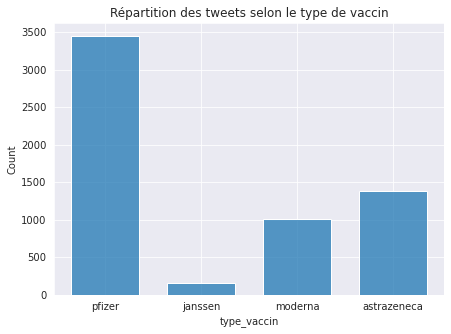

In [34]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="type_vaccin",  shrink=0.7)
plt.title("Répartition des tweets selon le type de vaccin")
plt.show()

Pfizer est le vaccin le plus populaire étant donné qu'environ 3500 tweets l'ont cité. Il est suivi de AstraZeneca avec 1384 mentions et Moderna avec environ 1000 mentions. Janssen est très faiblement représenté avec seulement 159 tweets. 

In [35]:
df_tweets.groupby("label_car")["id"].count()

label_car
negatif    1104
neutre     1617
positif    3284
Name: id, dtype: int64

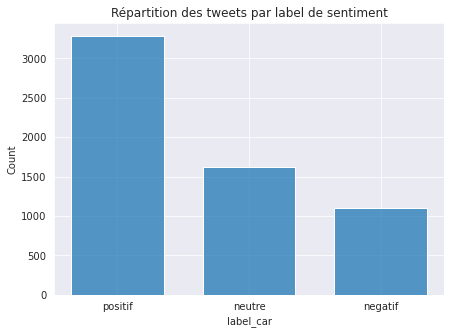

In [36]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
# customPalette = sns.set_palette(sns.diverging_palette(150, 10, n=3))

sns.histplot(df_tweets.sort_values("label_car", ascending=False), x="label_car",  shrink=0.7)# , palette=customPalette)
plt.title("Répartition des tweets par label de sentiment")
plt.show()

Près de la moitié des tweets ont été désignés par TextBlob comme positifs en terme de sentiment, l'autre moitié étant constituée de 1203 tweets négatifs et de 1495 tweets neutres.

#### Relation entre le type de sentiment et les autres variables

In [37]:
df_tweets.groupby([ "type_vaccin", "label_car"])["id"].count()

type_vaccin  label_car
astrazeneca  negatif       264
             neutre        374
             positif       746
janssen      negatif        33
             neutre         40
             positif        86
moderna      negatif       195
             neutre        266
             positif       552
pfizer       negatif       612
             neutre        937
             positif      1900
Name: id, dtype: int64

<Figure size 720x504 with 0 Axes>

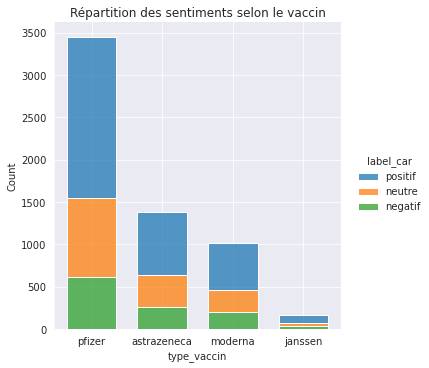

In [38]:
plt.figure(figsize=(10, 7))
# sns.color_palette("Spectral", as_cmap=True)
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(df_tweets.sort_values("label_car", ascending=False), x="type_vaccin", hue="label_car", multiple="stack", shrink=0.7)
plt.title("Répartition des sentiments selon le vaccin")
plt.show()

Pour tous les types de vaccins, les tweets "positifs" sont les plus représentés suivis des tweets neutres et enfin des tweets négatifs. Cette répartition semble identique d'un vaccin à l'autre, ce qui suggère une indépendance entre le type de sentiment et le type de vaccin. Pour être plus éclairé, on va appliquer le test d'indépendance de Khi-deux.

##### Test d'indépendance de Khi-deux

Il s'agit 

In [39]:
cont=pd.crosstab(df_tweets["label_car"],df_tweets["type_vaccin"])
khi2, pval , ddl , contingent_theorique = chi2_contingency(cont)
print('statistic: ',khi2, '\nP-value: ',pval ,'\nddl: ', ddl)

def cramers(crosstab):
    chi2= chi2_contingency(crosstab)[0]
    n=sum(crosstab.sum())
    return np.sqrt(chi2/(n*(min(crosstab.shape)-1)))

statistic:  2.7333044513591265 
P-value:  0.8414978871618547 
ddl:  6


Au seuil de 5%, on ne rejette pas l'hypothèse nulle d'indépendance entre le type de sentiment et le type de vaccin, ce qui confirme l'information apportée par le graphique ci-dessus. les différents vaccins sont vus de la même façon.

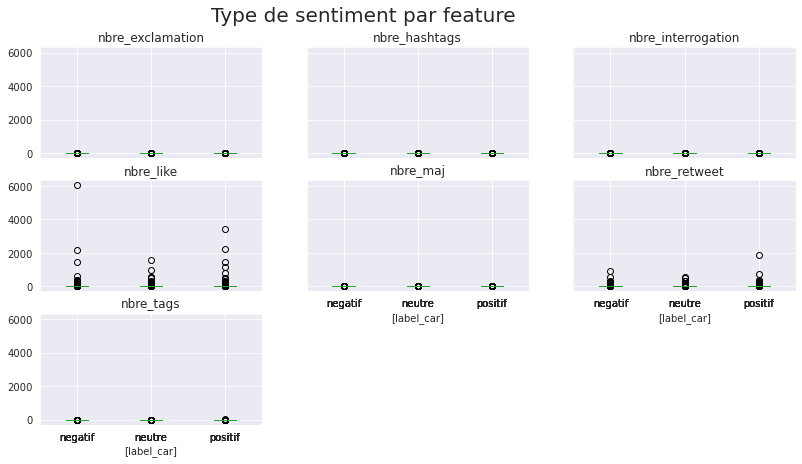

In [40]:
df1 = df_tweets[["label_car", "nbre_like", "nbre_retweet" , "nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]]
df1.boxplot(by='label_car',figsize=(15,7))
plt.suptitle("Type de sentiment par feature",fontsize=20)
plt.subplots_adjust(left=0.2, wspace=0.2, top=0.9)
plt.show()

En dehors du nombre de like et de retweets, les autres features semblent ne pas influencer le type de sentiment au regard de la répartition uniforme de ses modalités pour chaque feature. Pour en être sûr, nous allons dans la cellule qui suit effectuer le test de Kruskall Wallis d'égalité des moyennes entre les différents groupes formés par la variable cible (***label_car***) et chaque feature.

##### Test de Kruskal Wallis d'égalité des moyennes

Ce test 

In [41]:
# Test de Kruskal Wallis d'égalité des moyennes
def test_KW(var):
    print("label_car # "+var)
    kstat, pval = scipy.stats.kruskal(*[group[var].values for name, group in df1.groupby("label_car")])
    print('statistic: {:.4f}'.format(kstat)), print('P_value : {:1.6f}\n'.format(pval))

liste_vars = ["nbre_like", "nbre_retweet" , "nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj" ]

for var in liste_vars :
    test_KW(var)

label_car # nbre_like
statistic: 16.5248
P_value : 0.000258

label_car # nbre_retweet
statistic: 9.9574
P_value : 0.006883

label_car # nbre_hashtags
statistic: 1.8996
P_value : 0.386825

label_car # nbre_tags
statistic: 21.0414
P_value : 0.000027

label_car # nbre_exclamation
statistic: 59.3580
P_value : 0.000000

label_car # nbre_interrogation
statistic: 2.0084
P_value : 0.366344

label_car # nbre_maj
statistic: 21.9724
P_value : 0.000017



Les résultats suggèrent le rejet de l'hypothèse nulle d'égalité des moyennes pour les variables 
***nbre_like, nbre_retweet, nbre_tags, nbre_exclamtion*** et ***nbre_maj*** au seuil de 5%. Ce qui prétend que ces variables influencent le type de sentiment contenu dans un tweet.

##### Corrélation entre les features

<AxesSubplot:>

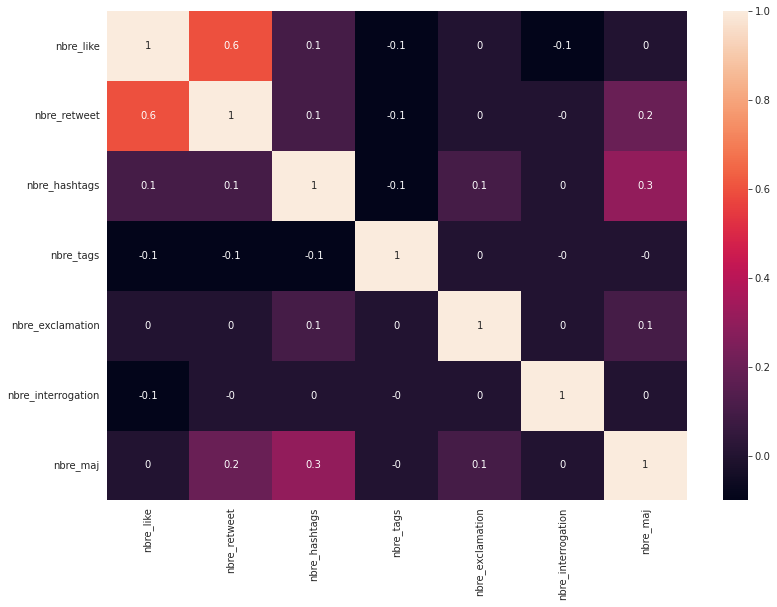

In [42]:
matrice_corr = df_tweets[["nbre_like", "nbre_retweet" , "nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]].corr(method='spearman').round(1)
f, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(data=matrice_corr, annot=True, center=None)

D'après la matrice de corrélations ci-dessus, seuls le nombre de like et le nombre de retweet sont fortement corrélés (coefficient = 0,6), ce qui est normal car plus on like, plus on a tendence à partager.

#### Analyse temporelle

Dans cette partie, nous verrons si nous pouvons explorer des tendances par rapport au temps.   
Premièrement, il est utile de visualiser la distribution temporelle de tous les tweets dans l'ensemble de données.

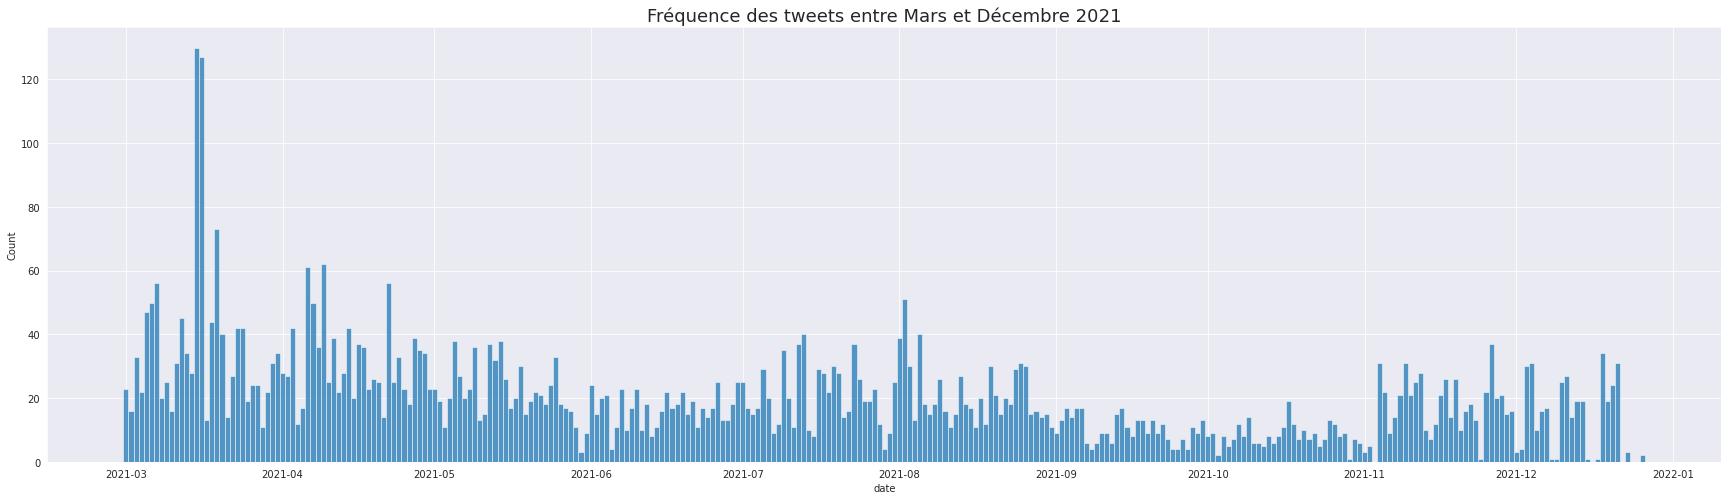

In [78]:
# Evolution de la fréquence des tweets entre mars et Décembre 2021
plt.figure(figsize=(30, 8))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="date")
plt.title("Fréquence des tweets entre Mars et Décembre 2021", size=18)
plt.show()

Les commentaires sur les vaccins étaient beaucoup plus récurrents sur la période mars debut juin, avec un pic en mi mars. Ce qui est compréhensible car cette période marque le moment à partir duquel l'information de l'exigence du passe sanitaire et donc du vaccin pour accéder aux lieux publics a été publiée, ce qui a suscité beaucoup de commentaires de la part des internautes. Ces commentaires ont eu une tendance baissière entre septembre et novembre et ont augmenté au cours du mois de décembre, ce qui pourrait s'expliquer par le nouveau variant covid qui fait rage et qui nécessite une vaccination massive de la population.

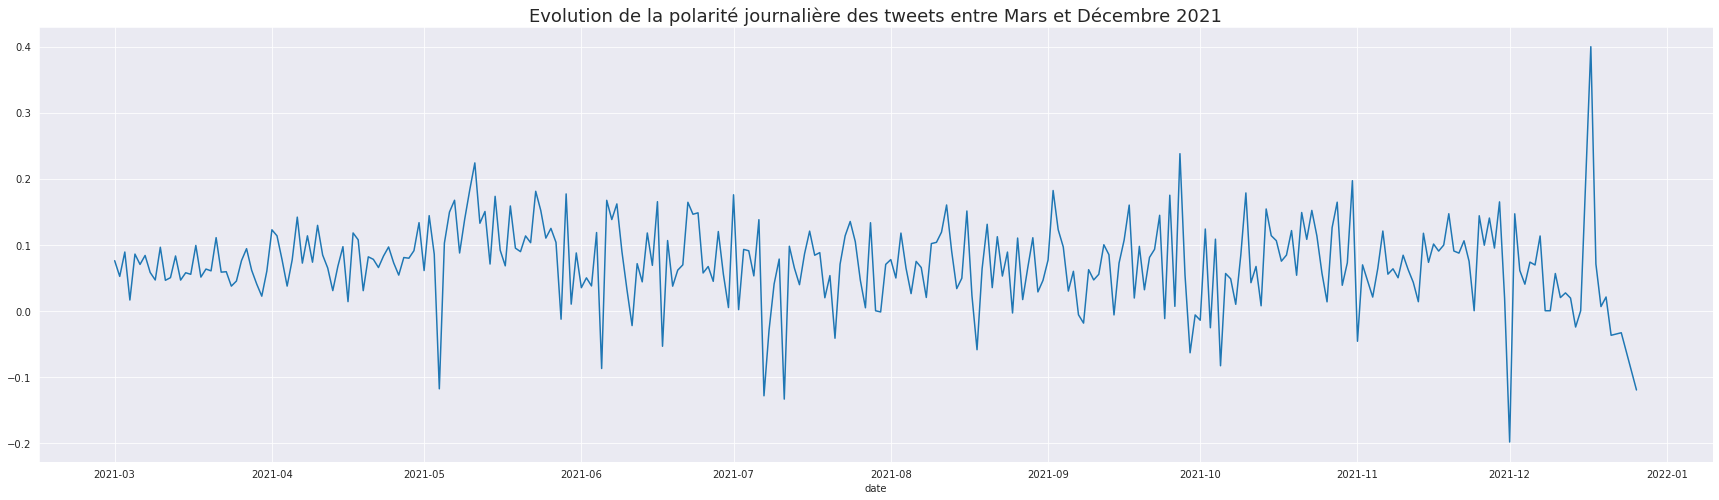

In [77]:
# Evolution de la polarité journalière des tweets entre Mars et Décembre 2021
plt.figure(figsize=(30, 8))
plt.xlabel('date')
df2 = df_tweets[['date','score_polarite']].groupby('date').mean()
#df2.set_index('date', inplace = True)
plt.plot(df2)
plt.title("Evolution de la polarité journalière des tweets entre Mars et Décembre 2021", size=18)
plt.show()

En moyenne, la polarité est au dessus de 0, quoiqu'en debut Mai, Juin, Juillet, Octobre et Décembre elle passe largement en dessous de 0, atteignant -0,2 en debut Décembre. Ce qui exprime la négativité dans les commentaires au cours de ces périodes. En mi Décembre, cette polarité passe à 0,4 au cours d'un jour donnée (polarité journalière moyenne la plus élevée sur toute la période), ce qui exprime une positivité des commentaires ce jour.

#### Visualisation avec WordCloud pour un vaccin donné

On se propose ici de visualiser les wordclouds selon le sentiment et selon le vaccin. Il ressort les mots redondants qui peuvent attirer l'attention sur un ou plusieurs aspects importants qui justifiraient le sentiment contenu dans les commentaires.

In [ ]:
import random

def couleur_rouge(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def couleur_verte(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def couleur_jaune(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [113]:
# définit les formes du wordcloud
# mask_bavette = np.array(Image.open('masque_fig.jpg'))

# mask_vaccin = np.array(Image.open('vaccin_.jpg'))

In [124]:
def trace_3_wordclouds_alignes(mots_neg, mots_neu, mots_pos):
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white', # mask=mask_bavette,# width=mask.shape[1], height=mask.shape[0],
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=couleur_rouge, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif", size=20)
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=couleur_jaune, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre", size=20)
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', #mask=mask_vaccin, 
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=couleur_verte, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif", size=20)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

In [125]:
def plot_wordcloud_vaccin(vaccin) :
    vaccin=str(vaccin)
    for x in df_tweets["type_vaccin"].unique():
        stop_words.append(x)
    df_cloud = df_tweets[df_tweets['type_vaccin']==vaccin] 
    df_pos = df_cloud[df_cloud['label']==1]
    mots_pos = ' '.join(df_pos['texte_lemmatise'])
    
    df_neg = df_cloud[df_cloud['label']==-1]
    mots_neg = ' '.join(df_neg['texte_lemmatise'])
    
    df_neu = df_cloud[df_cloud['label']==0]
    mots_neu = ' '.join(df_neu['texte_lemmatise'])
    
    trace_3_wordclouds_alignes(mots_neg, mots_neu, mots_pos)

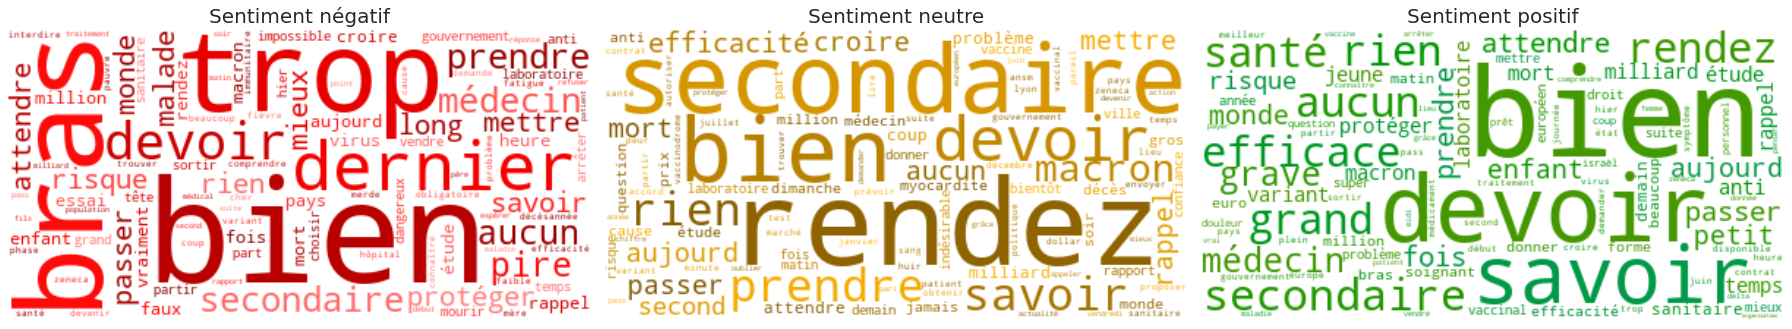

In [126]:
plot_wordcloud_vaccin("pfizer")

En dehors des mots tels que ***bein, devoir*** que l'on retrouve dans les wordclouds des 3 types de sentiments, l'on constate que les commentaires à connotation négative sur pfizer ont également mis l'accent sur ***risque, malade, virus, pire***,... et ceux à connotation positive ont mis l'accent sur ***efficace, santé***, ...

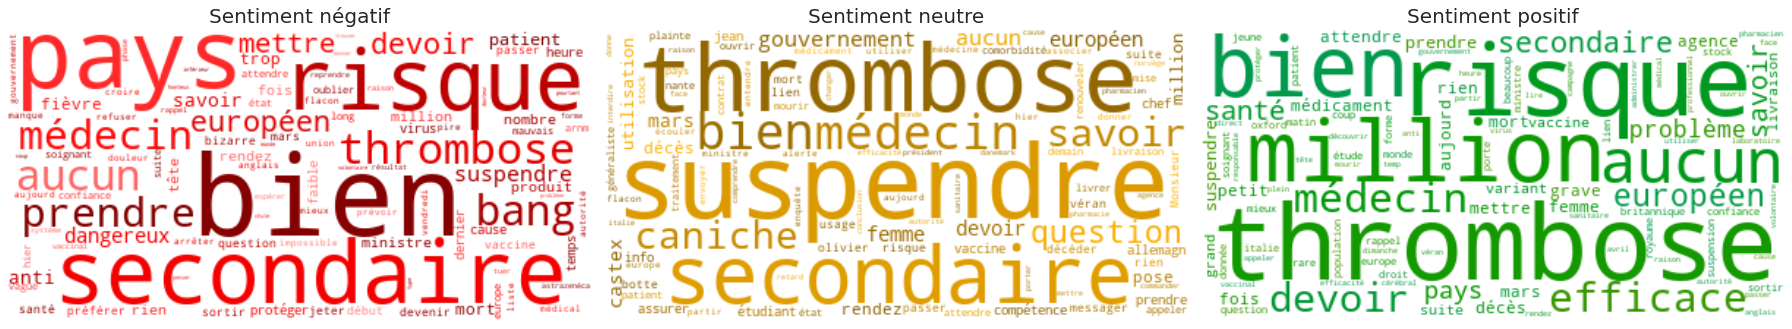

In [49]:
plot_wordcloud_vaccin("astrazeneca")

Pour astrazeneca, l'accent est mis sur ***thrombose*** pour les sentiments neutre et positif, ce qui signifie que ce mot n'a pas une connotation négative ici. Il est mis pour refuter l'une des croyances des non vaccinés. Le terme ***efficace*** revient dans le wordcloud des sentiments positifs, ce qui matérialise l'efficacité du vaccin. On remarque également ***aucun risque*** pour les sentiments positifs.

#  Modélisation

Cette section concerne la modélisation où un topic modeling ( Latent Dirichlet Allocation Model) et un modèle d'apprentissage supervisé (Régression logistique multinomiale) 

## Topic modeling : Latent Dirichlet Allocation (LDA) Model 

+ Le topic modeling est un modèle permettant de déterminer des sujets ou des thèmes abstraits d'un documents. Il est utilisé dans plusieurs domaines notamment en marketing pour analyser la satisfaction de la clientèle afin de leur proposer des produits plus ciblés. Il est également utilisé en science sociale notamment pour l'analyse des sentiments de la population sur un sujet de politique économique d'actuaité. Les tweets font partis des données sur lesquelles ce modèle est de plus en plus appliqué. Il comporte en général trois algorithme dont le LDA qui est celui utilisé ici.
+ LDA est un modèle probabiliste et algorithmique parcourant les messages pour former des groupes de mots qui co-occurrent souvent et ainsi découvrir des thèmes. 

#### LDA par type de sentiment 

Ici nous choisissons de ressortir des thèmes par type de sentiments pour par la suite construire des wordclouds et comparer avec ceux construits plus haut afin de voir si le modèle apporte une amélioration à ce qui a déjà été fait.

In [50]:
def model_lda(data):
    # créer un dictionnaire
    id2word = corpora.Dictionary(data) 
    # Créer un corpus
    texts = data
    # Prendre la position de chaque élement au sein de chaque liste
    corpus = [id2word.doc2bow(text) for text in texts]

    # nombre de sujets
    num_topics = 20

    # Construction du modèle LDA pour chaque type de sentiment
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    # Principaux mots des sujets ressortis
    sujet = lda_model.print_topics()
    return sujet

In [51]:
lda_negatif = model_lda(df_tweets[df_tweets["label_car"] == "negatif"]["liste_mots"])
lda_positif = model_lda(df_tweets[df_tweets["label_car"] == "positif"]["liste_mots"])
lda_neutre = model_lda(df_tweets[df_tweets["label_car"] == "neutre"]["liste_mots"])

In [52]:
# Liste des mots des sujets détectés par le LDA pour chaque type de sentiment
num_topics=20
liste=[]
def sujet_detecte(lda):
    for i in range(num_topics):
        for x in re.sub(r"[\+\*]","",(re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", lda[i][1]))).split('"'):
            if len(x)>2:
                liste.append(x)
    return liste

In [53]:
sujets_negatif = sujet_detecte(lda_negatif)
sujets_neutre = sujet_detecte(lda_neutre)
sujets_positif = sujet_detecte(lda_positif)

#### Wordcloud par type de sentiment à partir des résultats du modèle LDA

In [54]:
def plot_wordcloud_label() :
    # joindre les tweets en une chaine de caractere par type de sentiment
    mots_pos = ' '.join(sujets_positif)
    mots_neg = ' '.join(sujets_negatif)
    mots_neu = ' '.join(sujets_neutre)

    for x in ["pfizer", "moderna", "astrazeneca", "janssen"]:
        stop_words.append(x)
        
    trace_3_wordclouds_alignes(mots_neg, mots_neu, mots_pos)

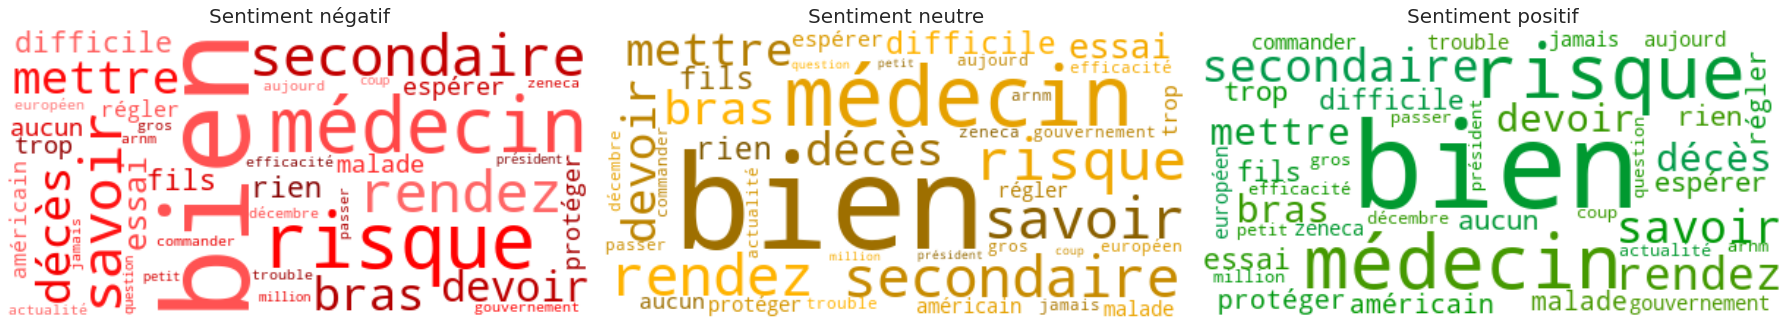

In [55]:
plot_wordcloud_label() 

## Régression logistique

#### Echantillonnage

In [56]:
df_tweets_copy = df_tweets.copy()
df_tweets_copy.drop_duplicates(subset = ["texte"], keep = 'first', inplace = True, ignore_index = True)
df_log_reg = df_tweets_copy[['label', 'nbre_like', 'nbre_retweet', 'nbre_hashtags', 'nbre_tags', 
                             'nbre_exclamation', 'nbre_interrogation', 'nbre_maj']]

In [57]:
print(df_tweets["label"].value_counts(normalize=True))

 1    0.546878
 0    0.269276
-1    0.183847
Name: label, dtype: float64


In [75]:
print("Nombre de tweets positifs:",len (df_tweets[df_tweets["label"]==1]), "\nNombre de tweets neutres:",len (df_tweets[df_tweets["label"]==0]), "\nNombre de tweets négatifs:",len (df_tweets[df_tweets["label"]==-1]))

Nombre de tweets positifs: 3284 
Nombre de tweets neutres: 1617 
Nombre de tweets négatifs: 1104


Etant donné qu'il y a moins de tweets négatifs (1203 tweets), il faut constituer un dataframe avec 1203 tweets par label pour éviter le biais de surapprentissage causé par une modalité surreprésentée de la variable cible (ici la variable 'label')

In [58]:
# Création d'un dataframe qui équilibre les tweets par label (même nobre de tweets pour chaque label) par tirage aléatoire
df = df_tweets[['label', 'nbre_like', 'nbre_retweet', 'nbre_hashtags', 'nbre_tags', 'nbre_exclamation', 'nbre_interrogation', 'nbre_maj']]

positif = df[df['label'].apply(lambda x: x == 1)]

neutre = df[df['label'].apply(lambda x: x == 0)]

negatif = df[df['label'].apply(lambda x: x == -1)]

seed(430)
A = positif.sample(n=1203, 
                   frac=None,
                   replace=False,
                   weights=None,
                   random_state=None,
                   axis=None)

B = neutre.sample(n=1203, 
                  frac=None,
                  replace=False,
                  weights=None,
                  random_state=None,
                  axis=None)

base_model = pd.concat([A, B, negatif], ignore_index=True)

len(base_model)

3510

In [59]:
# Partage de l'échantillon en échantillon d'apprentissage et en échantillon test
train, test = train_test_split(base_model, test_size=0.20, random_state=1, stratify=base_model.label)
# train.head()

In [60]:
# Division de la base en variable cible et variables indépendantes
y_train = train.iloc[:,0]
X_train = train.iloc[:,1:]

y_test = test.iloc[:,0]
X_test = test.iloc[:,1:]

In [61]:
X_train.shape

(2808, 7)

#### Model logit multinomial

In [62]:
model_logit = sm.MNLogit(y_train, sm.add_constant(X_train))
resultat = model_logit.fit()
stats1 = resultat.summary()
# stats2 = resultat.summary2()
print(stats1)
# print(stats2)

Optimization terminated successfully.
         Current function value: 1.084937
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                  label   No. Observations:                 2808
Model:                        MNLogit   Df Residuals:                     2792
Method:                           MLE   Df Model:                           14
Date:                Thu, 06 Jan 2022   Pseudo R-squ.:                 0.01172
Time:                        09:34:25   Log-Likelihood:                -3046.5
converged:                       True   LL-Null:                       -3082.6
Covariance Type:            nonrobust   LLR p-value:                 7.519e-10
           label=0       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3288      0.073      4.491      0.000       0.185       0.472
nbre_

In [63]:
model_logit1 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train, y_train)
pred = model_logit1.predict(X_test)
matrice_confusion = pd.DataFrame(confusion_matrix(y_test, pred), index=["Negatif", "Neutre", "Positif"], columns=["predicted_negatif", "predicted_neutre", "predicted_positif"])
matrice_confusion

,predicted_negatif,predicted_neutre,predicted_positif
Negatif,26,119,76
Neutre,29,148,63
Positif,26,137,78


##### Quelques statistiques de robustesse du modèle

In [65]:
class_report = classification_report(y_test, pred)
print(class_report)

              precision    recall  f1-score   support

          -1       0.32      0.12      0.17       221
           0       0.37      0.62      0.46       240
           1       0.36      0.32      0.34       241

    accuracy                           0.36       702
   macro avg       0.35      0.35      0.32       702
weighted avg       0.35      0.36      0.33       702



In [64]:
# Taux de bon classement

print("Taux de bon classement: %.2f" % (metrics.accuracy_score(y_test, pred)*100),"%, ce qui est très faible.") 

Taux de bon classement: 35.90 %, ce qui est très faible


# Conclusion

+ **Limites** : la vaccination était un phénomène global incluant tout type de public. Les tweets obtenus n'ont pas tous été écrits selon les règles grammaticales. Cela a constitué une limite dans le nettoyage, la lemmatisation. Aussi, le domaine du NLP reste encore peu dévélopé pour la langue francaise et nous avions eu des difficultés dans la documentation.